In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
# Initialize Weights
def init_params(layer_size):
    params={}
    for i in range(1,len(layer_size)):
        params["W"+ str(i)]= np.random.randn(layer_size[i], layer_size[i-1])* .01
        #params["W"+ str(i)]= np.random.randint(low = -2, high= 4, size=(layer_size[i], layer_size[i-1]))*.1  # For Debugging
        params["b"+ str(i)]= np.zeros((layer_size[i],1))
    
    return params

In [3]:
# Onehot Encoder
def one_hot(Y, num_channels):
    m= np.shape(Y)[0]
    one_h= np.zeros((num_channels,m))
    index=0
    for i in Y:
        one_h[i, index]=1
        index= index+1
    
    return one_h  

In [4]:
# Sigmoid
def sigmoid(Z):
    sig= 1/ (1+ np.exp(Z))
    
    return sig    

In [5]:
# ReLU
def relu(Z):
    relu= np.maximum(0,Z)
    
    return relu

In [6]:
# Softmax
def softmax(Z):
    soft= np.exp(Z)/ (np.sum(np.exp(Z), axis=0))
    
    return soft

In [7]:
# Activation
def activation(Z, activation):
    if activation== "relu":
        A= relu(Z)
    elif activation== "sigmoid":
        A= sigmoid(Z)
    elif activation== "softmax":
        A=softmax(Z)
    
    return A   

In [8]:
# Softmax Backprop
def softmax_back(dA, caches, layer_num, Y_train):
    al, _, _, _ = caches[layer_num-1]
    sofback= al-Y_train
    
    return sofback

In [9]:
# Relu backprop
def relu_back(dA, caches, layer_num):
    _, _, _, Zl= caches[layer_num-1]
    relback= dA* np.heaviside(Zl, 0)
    
    return relback

In [10]:
# Forward Propagation 
def forward_prop_single(A_prev, W, b):
    Z= np.dot(W, A_prev) + b
    
    return Z

In [11]:
# Forward propagation final
def forw_prop(X_train, layer, params):
    
    layer_dim= layer["Dim"]
    layer_activs= layer["Activs"]
    
    L= len(layer_dim)
    #params= init_params(layer_dim) 
    caches=[]
    A= X_train
    
    for l in range(1, L):
        A_prev=A
        W= params["W" + str(l)]
        b= params["b" + str(l)]
        Z= forward_prop_single(A_prev, W, b)
        A= activation(Z, layer_activs[l-1])
        cache= (A, W, b, Z)
        caches.append(cache)
    
    return caches

In [12]:
# Defining Cost Function
def cost(Y_train, Y, params, lamda):
    m= np.shape(Y_train)[1]
    loss= -np.sum(np.multiply(Y_train, np.log(Y)), axis= 0)
    c= (1/m)*np.sum(loss)
    c= np.squeeze(c)
    reg=0
    for i in range(len(params)//2):
        reg= reg+ np.sum(np.square(params["W" + str(i+1)]))    
    reg=reg* (lamda/(2*m))
    c=c+reg
    
    return c

In [13]:
# Single backprop
def back_prop_single(dA, caches, layer_num, activation, X_train, Y_train, lamda):
    if activation== "relu":
        dZ= relu_back(dA, caches, layer_num)
    elif activation=="softmax":
        dZ= softmax_back(dA, caches, layer_num, Y_train)
    m= np.shape(dA)[1]    
    _, Wl, _, _= caches[layer_num-1]
    
    if layer_num==1:
        al_1= X_train
    else:
        al_1, _, _, _ = caches[layer_num-2]
        
    dW= (1/m)*np.dot(dZ ,np.transpose(al_1)) + (lamda/m)*Wl
    db= (1/m)* np.sum(dZ, axis=1, keepdims=True)
    dAl_1= np.dot(np.transpose(Wl), dZ)
    
    return dW, db, dAl_1, dZ    

In [14]:
# N layer backprop
def back_prop(Y_train, caches, layer, X_train, lamda):
    layer_dim= layer["Dim"]
    layer_activs= layer["Activs"]
    L= len(caches)
    A_L, _, _, _= caches[L-1]
    dA= -(Y_train/A_L) 
    grads={}
    grads["dA"+ str(L)]= dA
    
    for l in range(L, 0, -1):
        dW, db, dA, dZ= back_prop_single(dA, caches, l, layer_activs[l-1], X_train, Y_train, lamda)
        grads["dW" + str(l)]= dW
        grads["db" + str(l)]= db
        grads["dA" + str(l-1)]= dA
        grads["dZ" + str(l)]= dZ
        
    return grads

In [15]:
# Update params
def upd_params(grads, params, l_rate):
    parameters=params.copy()
    L=len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)]= parameters["W"+str(l+1)] -l_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)]= parameters["b"+str(l+1)] -l_rate*grads["db"+str(l+1)]
        
    return parameters

In [16]:
# Accuracy
def acc(X_dev, Y_dev, params, layer):
    dev_cache= forw_prop(X_dev, layer, params)
    preds, _, _, _= dev_cache[len(dev_cache)-1]
    preds= np.argmax(preds, axis=0)
    correct= np.sum(preds== Y_dev)
    accurate= correct/ np.shape(Y_dev)[0]
    
    return preds,accurate

In [ ]:
#MAIN

# For Debugging 
'''
X_train= np.array([[1, 2, 1], [2, 1, 3], [3, 1, 3], [4, 3, 3]])
Y_train= np.array([[1, 0, 0], [0, 0, 0], [0, 1, 0], [0, 0, 1]])


Y_train= np.array([[0,1,0,0,0,1,0], [0,0,1,0,1,0,0], [0,0,0,1,0,0,1], [1,0,0,0,0,0,0]])
X_train= np.array([[10,80,11,49,15,55,32], [20,70,19,60, 85,16, 43], [30,60,15,70,9,36,69], [40,50,13,38,10,48,24]])
X_mean= np.mean(X_train, axis= 1, keepdims=True)
X_std= np.std(X_train, axis=1, keepdims=True) 
X_train= (X_train-X_mean)/X_std
m_train= 7
'''
# Import and one_hot encoding 
data= pd.read_csv(r'E:\My files\Python\DL\Datasets\MNIST\train.csv')
data= np.array(data)
data= np.transpose(data)
m= np.shape(data)[1]             #Total examples
m_train= 41000                   #Number of examples to be used for training

X_train= data[1:785, 0:m_train]
X_train= X_train/255

Y_train= data[0, 0:m_train]
Y_train_acc= Y_train
Y_train= one_hot(Y_train, 10)

X_dev= data[1:785, m_train:m]
X_dev= X_dev/255
Y_dev= data[0, m_train:m]


#Layer Data
layer_data={ "Dim": [784,300,10], "Activs": ["relu", "softmax"]}


#Hyperparameters
epochs= 30                         #Iterations
rate = 0.5                         #learning rate
batch_size= 512                    #Mini-batch size
mini_batch= m_train // batch_size  #Number of mini-batches
lamda= 0                           #Regularization parameter

#Initialize parameters
params= init_params(layer_data["Dim"])
cost_history=[]
dev_acc=[]
train_acc=[]
print(params)

#Training the model. COMMENT WHEN IN INFERENCE MODE.
for ep in range(epochs):
   
    print("Epoch "+str(ep+1))
    
    #Adaptive Learning Rate
    if (ep+1)%26 ==0:
        rate = rate/2
            
    for batch in range(mini_batch):
        start_index= batch_size*batch
        end_index= min((batch+1)*batch_size, m_train)
       
        X_train_batch = X_train[:, start_index: end_index]
        Y_train_batch = Y_train[:, start_index: end_index]
        
   
        # Forward propagation
        for_cache= forw_prop(X_train_batch, layer_data, params)
        #for i in range(len(for_cache)):
            #print("A"+str(i+1),",W"+str(i+1), ",b"+str(i+1),",Z"+str(i+1),"\n", for_cache[i], '\n')
        Y,_,_,_= for_cache[-1]

        
        # Cost
        cost_forward= cost(Y_train_batch, Y, params, lamda)
        print("Cost:", cost_forward)
        cost_history.append(cost_forward)

        
        # Back Propagation
        gradients= back_prop(Y_train_batch, for_cache, layer_data, X_train_batch, lamda)
    
        #for i in  range(len(for_cache), 0, -1):
            #print("dA"+str(i)+": " ,gradients["dA"+str(i)], "\n")
            #print("dZ"+str(i)+": " ,gradients["dZ"+str(i)], "\n")
            #print("dW"+str(i)+": " ,gradients["dW"+str(i)], "\n")
            #print("db"+str(i)+": " ,gradients["db"+str(i)], "\n")

        # Update Parameters
        params = upd_params(gradients, params, rate)
        #print(params.items())
        
        
        _, accuracy= acc(X_dev, Y_dev, params, layer_data)
        dev_acc.append(accuracy)
        print("Dev Accuracy:", accuracy)
        
        _, accuracy= acc(X_train, Y_train_acc, params, layer_data)
        train_acc.append(accuracy)
        print("Train Accuracy:", accuracy, "\n")

In [ ]:
'''
# For loading exisiting models. UNCOMMENT WHEN IN INFERENCE MODE. 

with open('97dot6_MNIST_300units_30ep_512mbgd_0lamda.json', 'rb') as fp:
    params=pickle.load(fp)

print(params)

_, accuracy= acc(X_dev, Y_dev, params, layer_data)
print("Dev Accuracy:", accuracy)

_, accuracy= acc(X_train, Y_train_acc, params, layer_data)
print("Train Accuracy:", accuracy, "\n")
'''

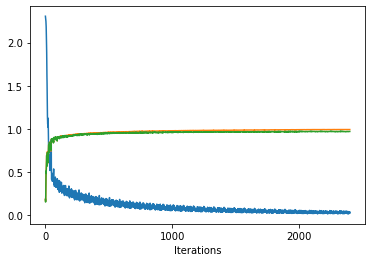

In [21]:
# Plotting cost and training accuracy over iterations. COMMENT WHEN IN INFERENCE MODE.
%matplotlib inline
x_ticks= [i for i in range(0, len(cost_history), 1000)]
plt.plot(cost_history)
plt.xticks(x_ticks)
plt.xlabel("Iterations")
plt.plot(train_acc)
plt.plot(dev_acc)
plt.savefig('Training_Graph.png')


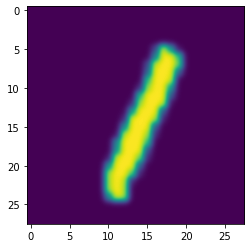

That's 1


In [19]:
# Loading random example from dev set and predicting it
eg= random.randint(0, m-m_train)
plt.imshow(np.reshape(X_dev[:, eg], (28,28)), interpolation='gaussian')
plt.show()
example= np.reshape(X_dev[:, eg], (784,1))
hehe = forw_prop(example, layer_data, params)
prediction, _, _, _= hehe[len(hehe)-1]
prediction= np.squeeze(np.argmax(prediction, axis=0))
print("That's", prediction)

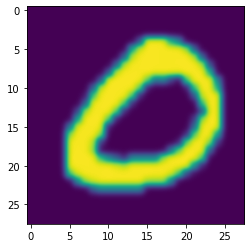

That's 0


In [20]:
# Loading random Test set examples to evaluate performance
X_test= np.array(pd.read_csv(r'E:\My files\Python\DL\Datasets\MNIST\test.csv'))
X_test= np.transpose(X_test)
X_test=X_test/255

eg= random.randint(0, np.shape(X_test)[1])

plt.imshow(np.reshape(X_test[:, eg], (28,28)), interpolation='gaussian')
plt.show()
example= np.reshape(X_test[:, eg], (784,1))
hehe = forw_prop(example, layer_data, params)
prediction, _, _, _= hehe[len(hehe)-1]
prediction= np.squeeze(np.argmax(prediction, axis=0))
print("That's", prediction)

In [ ]:
# Saving trained weights
print(params)
with open('filename.json', 'wb') as fp:
    pickle.dump(params, fp)
    
with open('filename.json', 'rb') as fp:
    data=pickle.load(fp)

print(data)